## Bike sharing 回归训练
#### 王中琦 1120190892

In [1]:
import pandas as pd

df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
# 课上笔记
# 1、初筛，比如日期对数据的重要性
# 2、选择有效特征，注意处理数据格式
# 3、考虑到分类属性，针对数据进行讨论

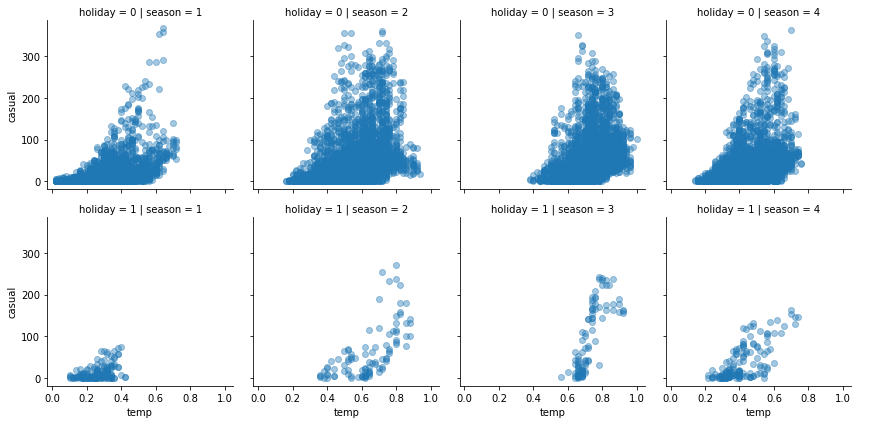

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

grid = sns.FacetGrid(df, row='holiday', col='season')
grid.map(plt.scatter, 'temp', 'casual', alpha=0.4)
grid.add_legend()

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'average usage num each day')]

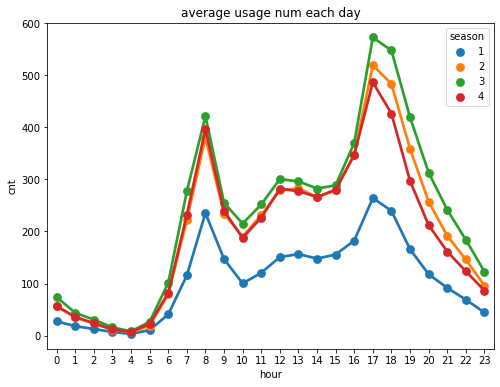

In [4]:
# 观察不同季节中不同时间点用户数量
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
hourAggregated = pd.DataFrame(df.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["season"], data=hourAggregated, join=True, ax=ax)
ax.set(xlabel='hour', title='average usage num each day')

In [5]:
df['dteday'] = df['dteday'].apply(pd.to_datetime)
df['day'] = df['dteday'].apply(lambda x:x.day)

# 归一化操作
df['temp'] = (df['temp']-df['temp'].mean())/df['temp'].std()
df['atemp'] = (df['atemp']-df['atemp'].mean())/df['atemp'].std()
df['hum'] = (df['hum']-df['hum'].mean())/df['hum'].std()
df['windspeed'] = (df['windspeed']-df['windspeed'].mean())/df['windspeed'].std()

df.drop(['dteday'], axis=1, inplace=True)
# df.drop(['month'], axis=1, inplace=True)

df.sample(5)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
7385,7386,4,0,11,8,0,3,1,1,-0.919146,-0.740616,1.569333,-1.553844,19,437,456,9
15087,15088,4,1,9,20,0,2,1,1,0.534976,0.846231,-0.348463,0.886073,37,388,425,25
6536,6537,4,0,10,22,0,2,1,1,0.015647,0.052516,0.480854,-0.456086,8,106,114,4
9848,9849,1,1,2,8,1,1,0,1,-1.542341,-1.710647,-0.192966,1.374057,9,111,120,20
414,415,1,0,1,7,0,3,1,2,-1.334609,-1.269565,1.517501,-0.699669,1,89,90,19


In [6]:
# 不能同时使用“regisetred”和“cnt”因为二者相加即为“cnt”
X = df[['season', 'yr','mnth','hr','holiday', 'weekday','workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day']]
y = df['cnt']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019)

X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.5, random_state=2022)

result = []

In [8]:
import math

def result_output(dtr,y_test):

    actu = []
    for i in y_test.keys():
        actu.append(y_test[i])

    sum1 = 0
    pre = dtr.predict(X_test)
    for i in range(len(y_test)):
        act = actu[i]
        pred = pre[i]
        try:
            sum1+=(math.log(pred+1)-math.log(act+1))**2
        except:
            sum1+=(math.log(act+1))**2

    sum1/=len(y_test)

    result = sum1 ** 0.5
    
    return result


In [9]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=11,min_samples_leaf=4,max_features=13,max_leaf_nodes=10000)
dtr.fit(X_train, y_train)
print(dtr.score(X_val, y_val))
result.append(result_output(dtr,y_test))

0.8902335097838985


In [10]:
# 应该在验证集上训练超参数

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=400,max_depth=15,min_samples_leaf=1,max_features=11,max_leaf_nodes=10000)
rfr.fit(X_train, y_train)
print(result_output(rfr, y_test))
result.append(result_output(rfr, y_test))

0.28715497469061574


In [11]:
from sklearn.linear_model import Lasso
lasso_m = Lasso(alpha=10,warm_start=False)
lasso_m.fit(X_train,y_train)
print(result_output(lasso_m,y_test))
result.append(result_output(lasso_m,y_test))

1.236919892613593


In [12]:
from sklearn.linear_model import Ridge

rige = Ridge(alpha=10)
rige.fit(X_train,y_train)
print(result_output(rige,y_test))
result.append(result_output(rige,y_test))

1.3198221149176375


In [13]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=1)
reg.fit(X_train,y_train)
print(result_output(reg,y_test))
result.append(result_output(reg,y_test))

1.5854722758195856


In [14]:
from sklearn.linear_model import BayesianRidge
reg = BayesianRidge()
reg.fit(X_train,y_train)
print(result_output(reg,y_test))
result.append(result_output(reg,y_test))

1.3185631104861086


In [15]:
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
print(result_output(model,y_test))
result.append(result_output(model,y_test))

1.3206180123210813


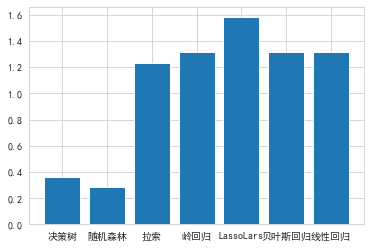

In [16]:
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
model = ['决策树','随机森林','拉索','岭回归','LassoLars','贝叶斯回归','线性回归']
import matplotlib.pyplot as plt

plt.bar(range(len(result)), result, tick_label=model)
plt.show()

#### 随机森林模型调参结果

|     特征名称     | 数值  |    结果    |
| :--------------: | :---: | :--------: |
|   n_estimator    |  10   |   0.3600   |
|                  |  100  | 0.3515 |
|                  |  200  |   0.3505   |
|                  |  400  |   **0.3500**   |
|    max_depth     |   3   |   0.8122   |
|                  |   5   |   0.6272   |
|                  |   8   |   0.4530   |
|                  |  15   | 0.3536 |
|                  |  25   |   0.3518   |
|                  |  50   |   **0.3512**   |
| min_samples_leaf |   1   | **0.3539** |
|                  |   2   |   0.3589   |
|                  |   3   |   0.3544   |
|   max_features   |   1   |   0.8451   |
|                  |   3   |   0.5308   |
|                  |   5   |   0.4181   |
|                  |   8   |   0.3550   |
|                  |   9   |   0.3517   |
|                  |  10   |   0.3502   |
|                  |  11   | **0.3490** |
|                  |  12   |   0.3505   |
|                  |  13   |   0.3522   |
|  max_leaf_nodes  |  100  |   0.6406   |
|                  | 1000  |   0.3981   |
|                  | 5000  |   0.3511   |
|                  | 10000 |   0.3505   |
|                  | 15000 |   0.3515   |
|                  | 20000 | **0.3490** |